# Random forest for pianist classification

## Import dependencies, set constants etc.

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_validate, train_test_split
from sklearn.inspection import permutation_importance

from src import utils
import src.visualise.visualise_utils as vutils
from src.features.features_utils import FeatureExtractor

In [2]:
# Define target/prediction variables
EXOG_INS = 'piano'
PREDICTION = 'pianist'

In [56]:
# Define predictor variables
PREDICTORS = [
    # Coupling of the pianist to the drummer, bassist, and themselves (i.e. influence of)
    'coupling_drums', 'coupling_bass', 'self_coupling',
    # Coupling of the bassist and drummer to the pianist (i.e. influence on)
    'coupling_bass_piano', 'coupling_drums_piano',
    # Tempo slope of average group position
    'tempo_slope',
    # Average tempo of the whole recording
    # TODO: should we use the tempo of the average group position?
    'tempo',
    # Median variability of 1/4 notes across a four-bar window
    # TODO: this should be a four-second window, not four-bar window!
    'rolling_std_median',
    # Average/variability in complexity of the IOIs across a four-bar window
    'entropy_mean', 'entropy_std',
    # Mean and variability of BUR values
    'bur_mean', 'bur_std',
    # Mean and variability of notes per second
    'ed_per_second_mean', 'ed_per_second_std',
    # Precision to each of our ensemble partners
    'bass_async_mean_pairwise_asynchrony','drums_async_mean_pairwise_asynchrony',
]

In [57]:
# These are the underlying categories each predictor belongs to
PREDICTORS_CATEGORIES = {
    'Swing': ['bur_mean', 'bur_std'],
    'Density': ['ed_per_second_mean', 'ed_per_second_std'],
    'Synchrony': ['bass_async_mean_pairwise_asynchrony', 'drums_async_mean_pairwise_asynchrony', 'mean_relative_asynchrony'],
    'Complexity': ['entropy_median', 'entropy_mean', 'entropy_std'],
    'Interaction': ['self_coupling', 'coupling_drums', 'coupling_bass', 'coupling_drums_piano', 'coupling_bass_piano'],
    'Tempo': ['rolling_std_median', 'tempo', 'tempo_slope']
}

In [58]:
# These variables are used for the optimization process
SEED = 42
N_FOLDS = 5
N_JOBS = -1
# Number of iterations to use in random sampling
N_ITER = 250

In [59]:
# Set the seed in NumPy for consistent results across function calls
np.random.seed(SEED)

## Load in data
We start by loading in the data we extracted from our `corpus_chronology` in `src\features\extract_features.py`. This gives us a list of `FeatureExtractor` classes (defined in `src\features\features_utils.py`).

In [60]:
features: list[FeatureExtractor] = utils.unserialise_object(fr'{utils.get_project_root()}\models\extracted_features_corpus_chronology')

We can now iterate through each `FeatureExtractor` class (equivalent to iterating through each track) and gather the attributes from this class that correspond to the features defined in `PREDICTORS`.

In [61]:
res = []
# Equivalent to iterating through each track
for track in features:
    track_res = {}
    # Iterate through each instrument in the trio
    for instr in utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys():
        # These are the results for the pianist
        if instr == EXOG_INS:
            be = track.IOI_onsetsrolling[EXOG_INS][4].summary_dict
            track_res.update({
                'entropy_mean': be['rolling_binary_entropy_mean'],
                'entropy_std': be['rolling_binary_entropy_std'],
                'entropy_count_nonzero': be['rolling_binary_entropy_count_nonzero'],
                **track.metadata[EXOG_INS],
                **track.IOI_beats[EXOG_INS].summary_dict,
                **track.BURs[EXOG_INS].summary_dict,
                **track.tempo_slope['group'].summary_dict,
                **track.asynchrony[EXOG_INS].summary_dict,
                **track.phase_correction[EXOG_INS][0].summary_dict[0],
                **track.event_density[EXOG_INS][1].summary_dict,
                **track.IOI_beatsrolling[EXOG_INS][4].summary_dict
            })
        # For the drummer and bassist, we just want their coupling to the piano and the number of observations in their regression
        else:
            track_res.update({
                f'coupling_{instr}_piano': track.phase_correction[instr][0].summary_dict[0]['coupling_piano'],
                f'nobs_{instr}': track.phase_correction[instr][0].summary_dict[0]['nobs']
            })
    # Once we have all the data for one instrument, append this to our results list
    res.append(track_res)

We can now convert all of these features to a dataframe, sort by the pianist in the recording, and print a few rows.

In [62]:
df = pd.DataFrame(res).sort_values('pianist').reset_index(drop=True)

## Clean dataset
### Identify outliers
When cleaning the dataset, we first need to identify outlying values in our features, which we can then impute or drop. We start by removing tracks where EITHER more than 1/3 of the audio is silent OR more than 2/3 of beats could not be matched with an onset. We remove these tracks completely, as we cannot be sure that any of the data is valid due to problems with either the source separation or onset detection on these tracks.

In [63]:
clean = df[(df['missing_beats_fraction'] < 2/3) | (df['fraction_silent'] < 1/3)].sort_values(by='pianist').reset_index(drop=True)

For the remaining variables, we set outlying values to `np.nan` so that we can set them to the group (pianist) average later, rather than removing the track completely. To start, we clean `self_coupling`, `coupling_bass`, or `coupling_drums` when `nobs < 30`: this means that we have fewer than 10 terms for each of our 3 predictors in the regression.

In [64]:
for col in ['self_coupling', 'coupling_bass', 'coupling_drums']:
    # If we have NaN obs, it's because the model failed to compile, so replace this with 0
    clean[f'nobs'] = clean[f'nobs'].fillna(0)
    clean.loc[clean['nobs'] < 30, col] = np.nan

For the same reason, we clean `coupling_bass_piano` (i.e. bass coupling to piano) when `nobs_bass < 30` (sim. for `coupling_drums_piano` and `nobs_drums`)

In [65]:
for col in ['bass', 'drums']:
    # If we have NaN obs, it's because the model failed to compile, so replace this with 0
    clean[f'nobs_{col}'] = clean[f'nobs_{col}'].fillna(0)
    clean.loc[clean[f'nobs_{col}'] < 30, f'coupling_{col}_piano'] = np.nan

We clean `bur_mean` and `bur_std` when `0.25 <= average_bur <= 4` (these are the values discussed by Corcoran and Frieler) OR `bur_count_nonzero < 10` (we have fewer than 10 BURs in the track).

In [66]:
for col in ['bur_mean', 'bur_std']:
    clean.loc[clean['bur_mean'] < 1/4, col] = np.nan
    clean.loc[clean['bur_mean'] > 4, col] = np.nan
    clean.loc[clean['bur_count_nonzero'] < 10, col] = np.nan

We clean `bass/drums_async` when `bass/drums_async_count_nonzero < 10`, i.e. we played on fewer than 10 beats with our partner.

In [67]:
for col in ['bass', 'drums']:
    clean.loc[clean[f'{col}_async_count_nonzero'] < 10, f'{col}_async_mean_pairwise_asynchrony'] = np.nan

We clean `mean_relative_asynchrony` when the combined `bass_async_count_nonzero + drums_async_count_nonzero < 20`, meaning we played on fewer than 20 beats with either of our partners.

In [68]:
# We sum up the asynchrony count for both partners in the trio
as_count = clean.loc[:, ['bass_async_count_nonzero', 'drums_async_count_nonzero']].sum(axis=1)
clean.loc[as_count < 20, 'mean_relative_asynchrony'] = np.nan

We clean `tempo_slope` when `tempo_slope.abs() < 0.15`, i.e. we accelerated (or decelerated) by more than 0.15 beats-per-minute-per-second. This is the upper limit of values suggested to be realistic for jazz ensembles in the control condition of our previous experiment.

In [69]:
clean.loc[clean['tempo_slope'].abs() > 0.15, 'tempo_slope'] = np.nan

We clean `rolling_std_median` when `rolling_std_median > 0.4`, i.e. the median standard deviation for a four-second window of 1/4 note beats is greater than 40 milliseconds. This is the upper limit of values for this variable from our earlier experiment.

In [70]:
clean.loc[clean['rolling_std_median'] > 0.4, 'rolling_std_median'] = np.nan

We clean `entropy_median` and `entropy_std` when we have fewer than 5 complete four-second windows over which to calculate this.

In [71]:
for col in ['mean', 'std']:
    clean.loc[clean['entropy_count_nonzero'] < 5, f'entropy_{col}'] = np.nan

### Impute missing values based on pianist averages
We can now group by our pianists and set the `np.nan` values to the mean for that pianist.

In [72]:
X = clean.groupby(PREDICTION)[PREDICTORS].transform(lambda x: x.fillna(x.mean()))

### Encode categorical prediction variable
Next, we need to encode our predictor variable (currently a list of names) to integers.

In [73]:
# We can store the labels for later use
pianist_labels = clean[PREDICTION].unique().tolist()
y = clean[PREDICTION].map({val: i for i, val in enumerate(pianist_labels)})

## Random Forest modelling
### Create the baseline model
Here, we just make random predictions of the pianist in each track in the test set.

In [21]:
accuracy_random = accuracy_score(y, np.random.randint(y.min(), y.max(), len(y)))
print(f"Random guess accuracy: {round(accuracy_random * 100, 2)}%")

Random guess accuracy: 7.42%


As expected, we'll be correct approximately one in ten times if we just guess the pianist at random. Random bullshit go!

### Create the initial model
This just uses the default parameters of `RandomForestClassifier`, without any attempt at optimisation.

In [22]:
rf_init = RandomForestClassifier(random_state=SEED)
results = cross_validate(
    estimator=rf_init,
    X=X,
    y=y,
    groups=y,
    cv=StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED),
    scoring='balanced_accuracy',
)
accuracy_init = results['test_score'].mean() * 100
print(f"Initial model accuracy on training set (after cross-validation): {round(accuracy_init, 2)}%")

Initial model accuracy on training set (after cross-validation): 41.1%


Even without any parameter tuning, the model is nearly three times as accurate as chance alone when predicting the training data.

### Hyperparameter tuning
Now, we use `RandomizedSearchCV` to test various possible options of parameters and find the optimized settings.

In [23]:
# Create the classifier object
rscv_rf = RandomForestClassifier(random_state=SEED)

In [24]:
# Define the parameter grid to sample from
rscv_params = dict(
    # The number of trees to grow in the forest
    n_estimators=[i for i in range(50, 1000, 100)],
    # Max number of features considered for splitting a node
    max_features=[None, 'sqrt', 'log2'],
    # Max number of levels in each tree
    max_depth=[None, *[i for i in range(10, 100, 10)]],
    # Whether to sample data points with our without replacement
    bootstrap=[True, False],
)

In [25]:
# Define the RandomizedSearchCV object
rscv = RandomizedSearchCV(
    estimator=rscv_rf,
    scoring='balanced_accuracy',
    param_distributions=rscv_params,
    n_iter=10,
    n_jobs=1,
    cv=StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED),
    random_state=SEED,
    verbose=10,
)

In [26]:
# Fit the random search object to the data
rscv.fit(X, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START bootstrap=True, max_depth=30, max_features=log2, n_estimators=50
[CV 1/5; 1/10] END bootstrap=True, max_depth=30, max_features=log2, n_estimators=50;, score=0.343 total time=   0.2s
[CV 2/5; 1/10] START bootstrap=True, max_depth=30, max_features=log2, n_estimators=50
[CV 2/5; 1/10] END bootstrap=True, max_depth=30, max_features=log2, n_estimators=50;, score=0.343 total time=   0.2s
[CV 3/5; 1/10] START bootstrap=True, max_depth=30, max_features=log2, n_estimators=50
[CV 3/5; 1/10] END bootstrap=True, max_depth=30, max_features=log2, n_estimators=50;, score=0.417 total time=   0.2s
[CV 4/5; 1/10] START bootstrap=True, max_depth=30, max_features=log2, n_estimators=50
[CV 4/5; 1/10] END bootstrap=True, max_depth=30, max_features=log2, n_estimators=50;, score=0.335 total time=   0.2s
[CV 5/5; 1/10] START bootstrap=True, max_depth=30, max_features=log2, n_estimators=50
[CV 5/5; 1/10] END bootstrap=True, max_de

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(random_state=42), n_jobs=1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30, 40, 50,
                                                      60, 70, 80, 90],
                                        'max_features': [None, 'sqrt', 'log2'],
                                        'n_estimators': [50, 150, 250, 350, 450,
                                                         550, 650, 750, 850,
                                                         950]},
                   random_state=42, scoring='balanced_accuracy', verbose=10)

In [27]:
# Get the parameters from the best estimate
best_params = rscv.best_estimator_.get_params()

### Fit the best model and test against the initial model

In [50]:
rf_best = RandomForestClassifier(**best_params)
results_best = cross_validate(
    estimator=rf_best,
    X=X,
    y=y,
    groups=y,
    cv=StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED),
    scoring='balanced_accuracy',
    return_estimator=True
)
accuracy_best = results_best['test_score'].mean() * 100
print(f"Optimized model accuracy (after cross-validation): {round(accuracy_best, 2)}%")
print(f'Improvement over initial model: {round(accuracy_best - accuracy_init, 2)}%')

Optimized model accuracy (after cross-validation): 40.67%
Improvement over initial model: -0.43%


Optimization lead to an increase in accuracy over the initial model of approximately +6%.

### Get feature importance

In [1]:
# test/train sets created by cross_validate.split from full dataset
# Iterate through test/train set combinations
    # Fit to the train set
    # Get feature importance from the test set for that split
    # Predict the test set
# Average feature importance across all splits
# Sum together all predictions to get final confusion matrix

In [118]:
rf_best = RandomForestClassifier(**best_params)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=SEED, stratify=y)
rf_best.fit(X_train, y_train)
result = permutation_importance(rf_best, X_test, y_test, n_repeats=10, random_state=SEED, n_jobs=N_JOBS)
forest_importances = pd.Series(result.importances_mean, index=X.columns)
print(forest_importances.sort_values())

self_coupling                           0.000000
bass_async_mean_pairwise_asynchrony     0.001754
ed_per_second_std                       0.007018
coupling_bass                           0.015789
coupling_drums_piano                    0.015789
entropy_mean                            0.015789
coupling_drums                          0.024561
entropy_std                             0.029825
bur_mean                                0.042105
coupling_bass_piano                     0.043860
tempo                                   0.043860
bur_std                                 0.063158
drums_async_mean_pairwise_asynchrony    0.066667
tempo_slope                             0.070175
ed_per_second_mean                      0.084211
rolling_std_median                      0.101754
dtype: float64


In [121]:
rf_best.fit(X, y)
result = permutation_importance(
    rf_best, X, y, n_repeats=10, random_state=SEED, n_jobs=N_JOBS
)
forest_importances = pd.Series(result.importances_mean, index=X.columns)
forest_importances.sort_values()

coupling_drums                          0.000000
coupling_bass                           0.000000
self_coupling                           0.000000
coupling_bass_piano                     0.000000
coupling_drums_piano                    0.000000
tempo                                   0.000000
entropy_mean                            0.000000
entropy_std                             0.000000
ed_per_second_std                       0.000000
bass_async_mean_pairwise_asynchrony     0.000000
drums_async_mean_pairwise_asynchrony    0.000000
bur_std                                 0.000707
ed_per_second_mean                      0.001060
tempo_slope                             0.001413
rolling_std_median                      0.018728
bur_mean                                0.040636
dtype: float64

## Plot results

### Plot feature importance
Which rhythmic features are most important in defining the personal style of a particular pianist?

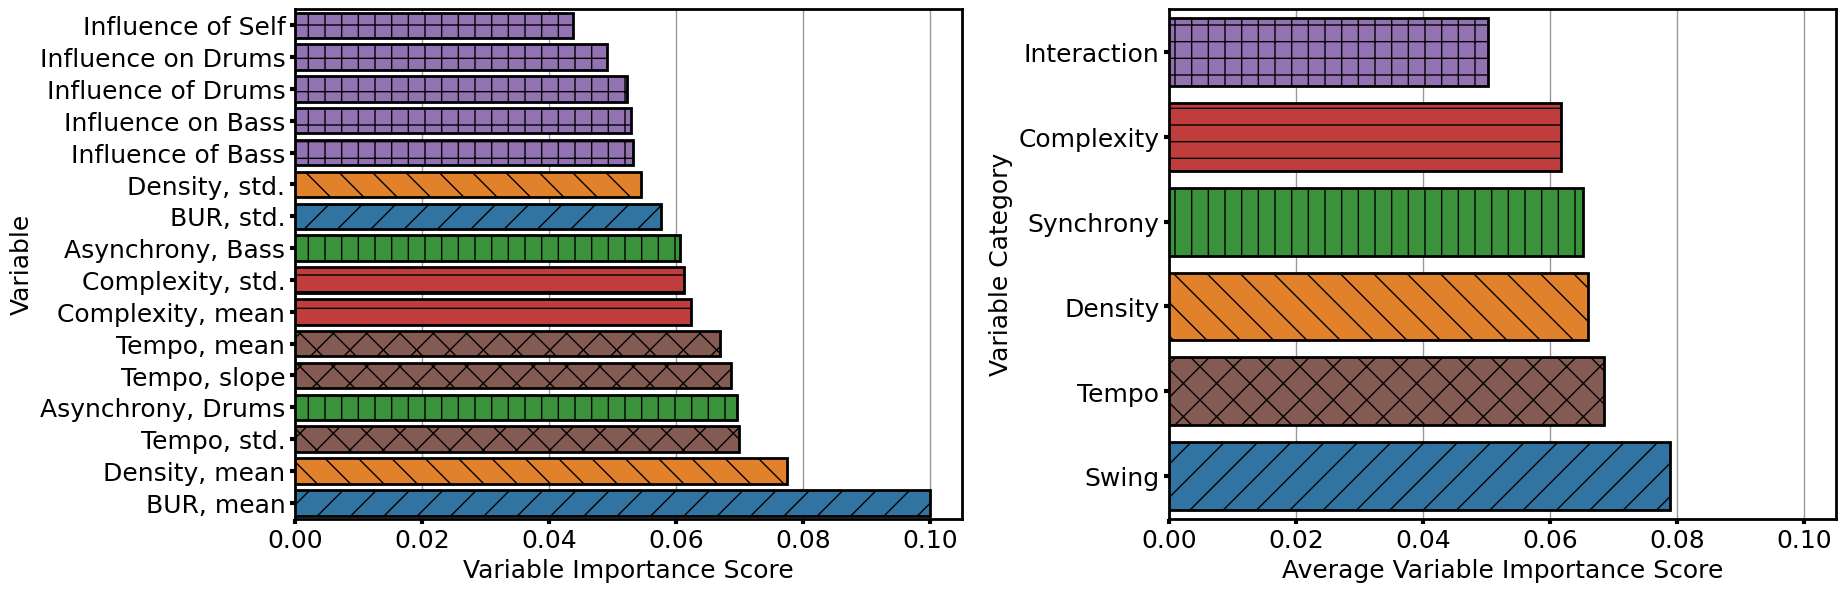

In [122]:
class BarPlotFeatureImportances(vutils.BasePlot):
    """Creates two barplots, showing (1) importance of all features and (2) average importance of feature category"""
    # These are the keywords we apply to all bar plots
    bar_kws = dict(
        dodge=False, edgecolor=vutils.BLACK, errorbar=None,
        lw=vutils.LINEWIDTH, seed=SEED, capsize=0.1, width=0.8,
        ls=vutils.LINESTYLE, hue_order=PREDICTORS_CATEGORIES.keys(),
        zorder=3, estimator=np.mean,
    )
    # These are the mappings we apply to the raw feature names
    col_mapping = {
        'bur_mean': 'BUR, mean',
        'ed_per_second_mean': 'Density, mean',
        'rolling_std_median': 'Tempo, std.',
        'entropy_median': 'Complexity, mean',
        'entropy_mean': 'Complexity, mean',
        'entropy_std': 'Complexity, std.',
        'tempo': 'Tempo, mean',
        'ed_per_second_std': 'Density, std.',
        'coupling_bass': 'Influence of Bass',
        'bass_async_mean_pairwise_asynchrony': 'Asynchrony, Bass',
        'drums_async_mean_pairwise_asynchrony': 'Asynchrony, Drums',
        'tempo_slope': 'Tempo, slope',
        'mean_relative_asynchrony': 'Asynchrony, Group',
        'bur_std': 'BUR, std.',
        'self_coupling': 'Influence of Self',
        'coupling_drums_piano': 'Influence on Drums',
        'coupling_bass_piano': 'Influence on Bass',
        'coupling_drums': 'Influence of Drums'
    }
    # This creates a new dictionary with a unique hash for each predictor category
    hatches = {k: h for k, h in zip(PREDICTORS_CATEGORIES.keys(), vutils.HATCHES)}

    def __init__(self, importances: pd.DataFrame, **kwargs):
        self.corpus_title = 'corpus_chronology'
        super().__init__(figure_title=fr'random_forest_plots\barplot_feature_importances_{self.corpus_title}', **kwargs)
        # Create both dataframes
        self.importances = self._format_df(importances)
        self.grouped_importances = (
            self.importances.groupby('category', as_index=False)
            .mean(numeric_only=True)
            .sort_values(by='value')
        )
        # Create subplot matrix
        self.fig, self.ax = plt.subplots(nrows=1, ncols=2, figsize=(vutils.WIDTH, vutils.WIDTH / 3), sharex=True, sharey=False)

    def _format_df(self, importances: pd.Series) -> pd.DataFrame:
        """Formats raw feature importance scores"""
        def get_category(val):
            """Returns the correct category for a given feature"""
            for cat, vals in PREDICTORS_CATEGORIES.items():
                if val in vals:
                    return cat

        # Initial formatting to the dataframe
        importances = (
            importances.reset_index(drop=False)
            .rename(columns={'index': 'variable', 0: 'value'})
            .sort_values(by='value', ascending=True)
        )
        # Get the category for each feature and format the variable name
        importances['category'] = importances['variable'].apply(get_category)
        importances['variable_'] = importances['variable'].map(self.col_mapping)
        return importances

    def _create_plot(self) -> plt.Axes:
        """Creates all plots in seaborn with given arguments"""
        sns.barplot(
            data=self.importances, x='value', y='variable_', hue='category',
            ax=self.ax[0], **self.bar_kws
        )
        return sns.barplot(
            data=self.grouped_importances, x='value', y='category',
            hue='category', ax=self.ax[1], **self.bar_kws
        )

    def add_hatches(self, ax: plt.Axes, df: pd.DataFrame) -> None:
        """Adds correct hatches to a barplot by category"""
        # Get the bars that are actually drawn on the plot, i.e. with non-zero width
        patches = [patch for patch in ax.patches if not np.isnan(patch.get_width())]
        # Sort these patches, so they align with the structure of our dataframe
        patches.sort(key=lambda x: x.get_width(), reverse=False)
        # Iterate through each patch and row together and set the hatch correctly
        for patch, (idx, val) in zip(patches, df.iterrows()):
            patch.set_hatch(self.hatches[val['category']])

    def _format_ax(self) -> None:
        """Formats axis-level properties"""
        # Set variable labelling
        self.ax[0].set(ylabel='Variable', xlabel='Variable Importance Score')
        self.ax[1].set(ylabel='Variable Category', xlabel='Average Variable Importance Score')
        # Iterate through each axis and the corresponding data
        for ax, df in zip(self.ax.flatten(), [self.importances, self.grouped_importances]):
            # Remove the legend
            ax.get_legend().remove()
            # Set the width of the edges and ticks
            plt.setp(ax.spines.values(), linewidth=vutils.LINEWIDTH, color=vutils.BLACK)
            ax.tick_params(axis='both', width=vutils.TICKWIDTH, color=vutils.BLACK)
            # Add a vertical grid
            ax.grid(zorder=0, axis='x', **vutils.GRID_KWS)
            # Add in the hatches to the bars
            self.add_hatches(ax, df)

    def _format_fig(self) -> None:
        """Formats figure-level attributes"""
        self.fig.tight_layout()


# Create a series containing feature importance from the model and feature names from the training data
feature_importance_cv = pd.Series(rf_best.feature_importances_, index=X.columns)
BarPlotFeatureImportances(feature_importance_cv).create_plot()
plt.show()

### Plot prediction errors by pianist
Which pianist's style is easiest to predict based on rhythmic features alone?

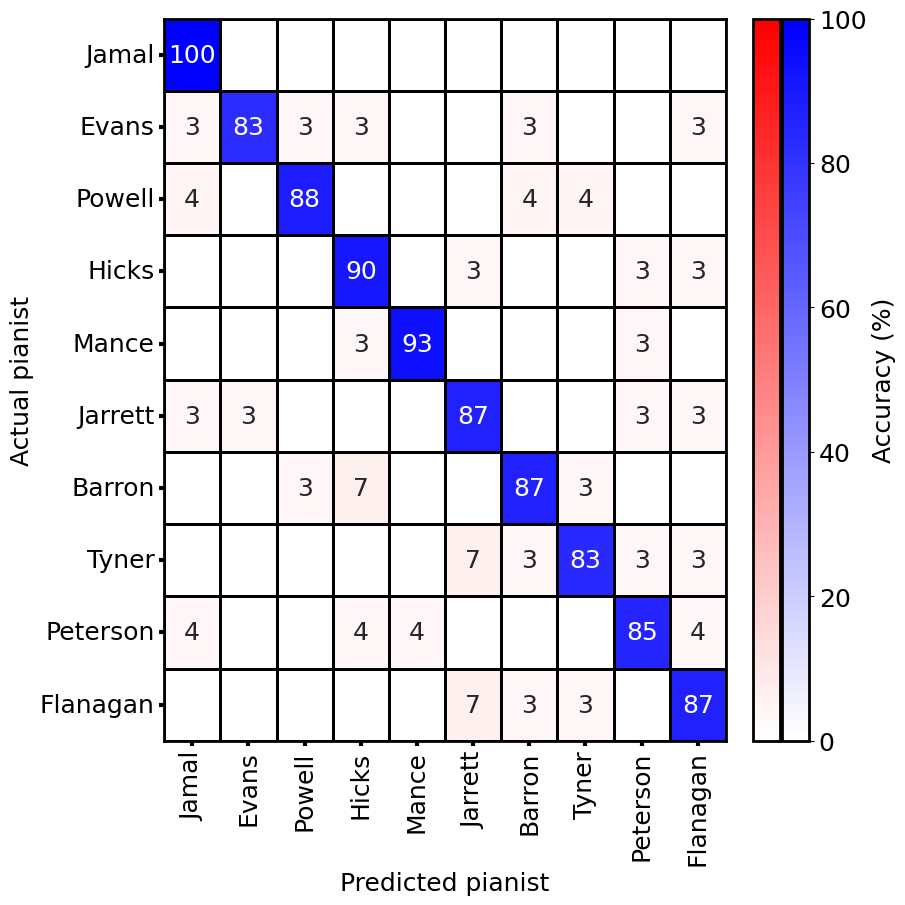

In [119]:
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

cm = confusion_matrix(y, rf_best.predict(X))
cmn = cm.astype(np.float64) / cm.sum(axis=1)[:, np.newaxis] * 100
off_diag_mask = np.eye(*cmn.shape, dtype=bool)
fig = plt.figure(figsize=(vutils.WIDTH / 2, vutils.WIDTH/2))
gs0 = mpl.gridspec.GridSpec(1, 2, width_ratios=[20, 2], hspace=0.0)
gs00 = mpl.gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[1], hspace=0.2)

ax = fig.add_subplot(gs0[0])
cax1 = fig.add_subplot(gs00[0])
cax2 = fig.add_subplot(gs00[1])

labs = [lab.split(' ')[-1] for lab in pianist_labels]
g = sns.heatmap(
    cmn, annot=True, fmt='.0f', xticklabels=labs, yticklabels=labs,
    ax=ax, cmap=LinearSegmentedColormap.from_list("Custom", [(1, 1, 1), (0, 0, 1)], N=100),
    linecolor=vutils.BLACK, linewidths=vutils.LINEWIDTH/2,
    square=False, cbar_kws=dict(label='Accuracy (%)'), mask=~off_diag_mask,
    vmin=0, vmax=100, cbar_ax=cax2
)
g = sns.heatmap(
    cmn, annot=True, fmt='.0f', xticklabels=labs, yticklabels=labs, cbar_ax=cax1,
    ax=ax, cmap=LinearSegmentedColormap.from_list("Custom", [(1, 1, 1), (1, 0, 0)], N=100),
    linecolor=vutils.BLACK, linewidths=vutils.LINEWIDTH/2,
    square=False, cbar_kws=dict(label='', ticks=[]), mask=off_diag_mask, vmin=0, vmax=100
)

for cax in [cax1, cax2]:
    for spine in cax.spines:
        cax.spines[spine].set_color(vutils.BLACK)
        cax.spines[spine].set_linewidth(vutils.LINEWIDTH)
for t in g.texts:
    if float(t.get_text()) > 0:
        t.set_text(t.get_text())
    else:
        t.set_text('')
for _, spine in ax.spines.items():
    spine.set_visible(True)
plt.setp(ax.spines.values(), linewidth=vutils.LINEWIDTH, color=vutils.BLACK)
ax.tick_params(axis='both', width=vutils.TICKWIDTH, color=vutils.BLACK)
ax.set(ylabel='Actual pianist', xlabel='Predicted pianist')
fig.tight_layout()
plt.show()

### Plot correlations between features

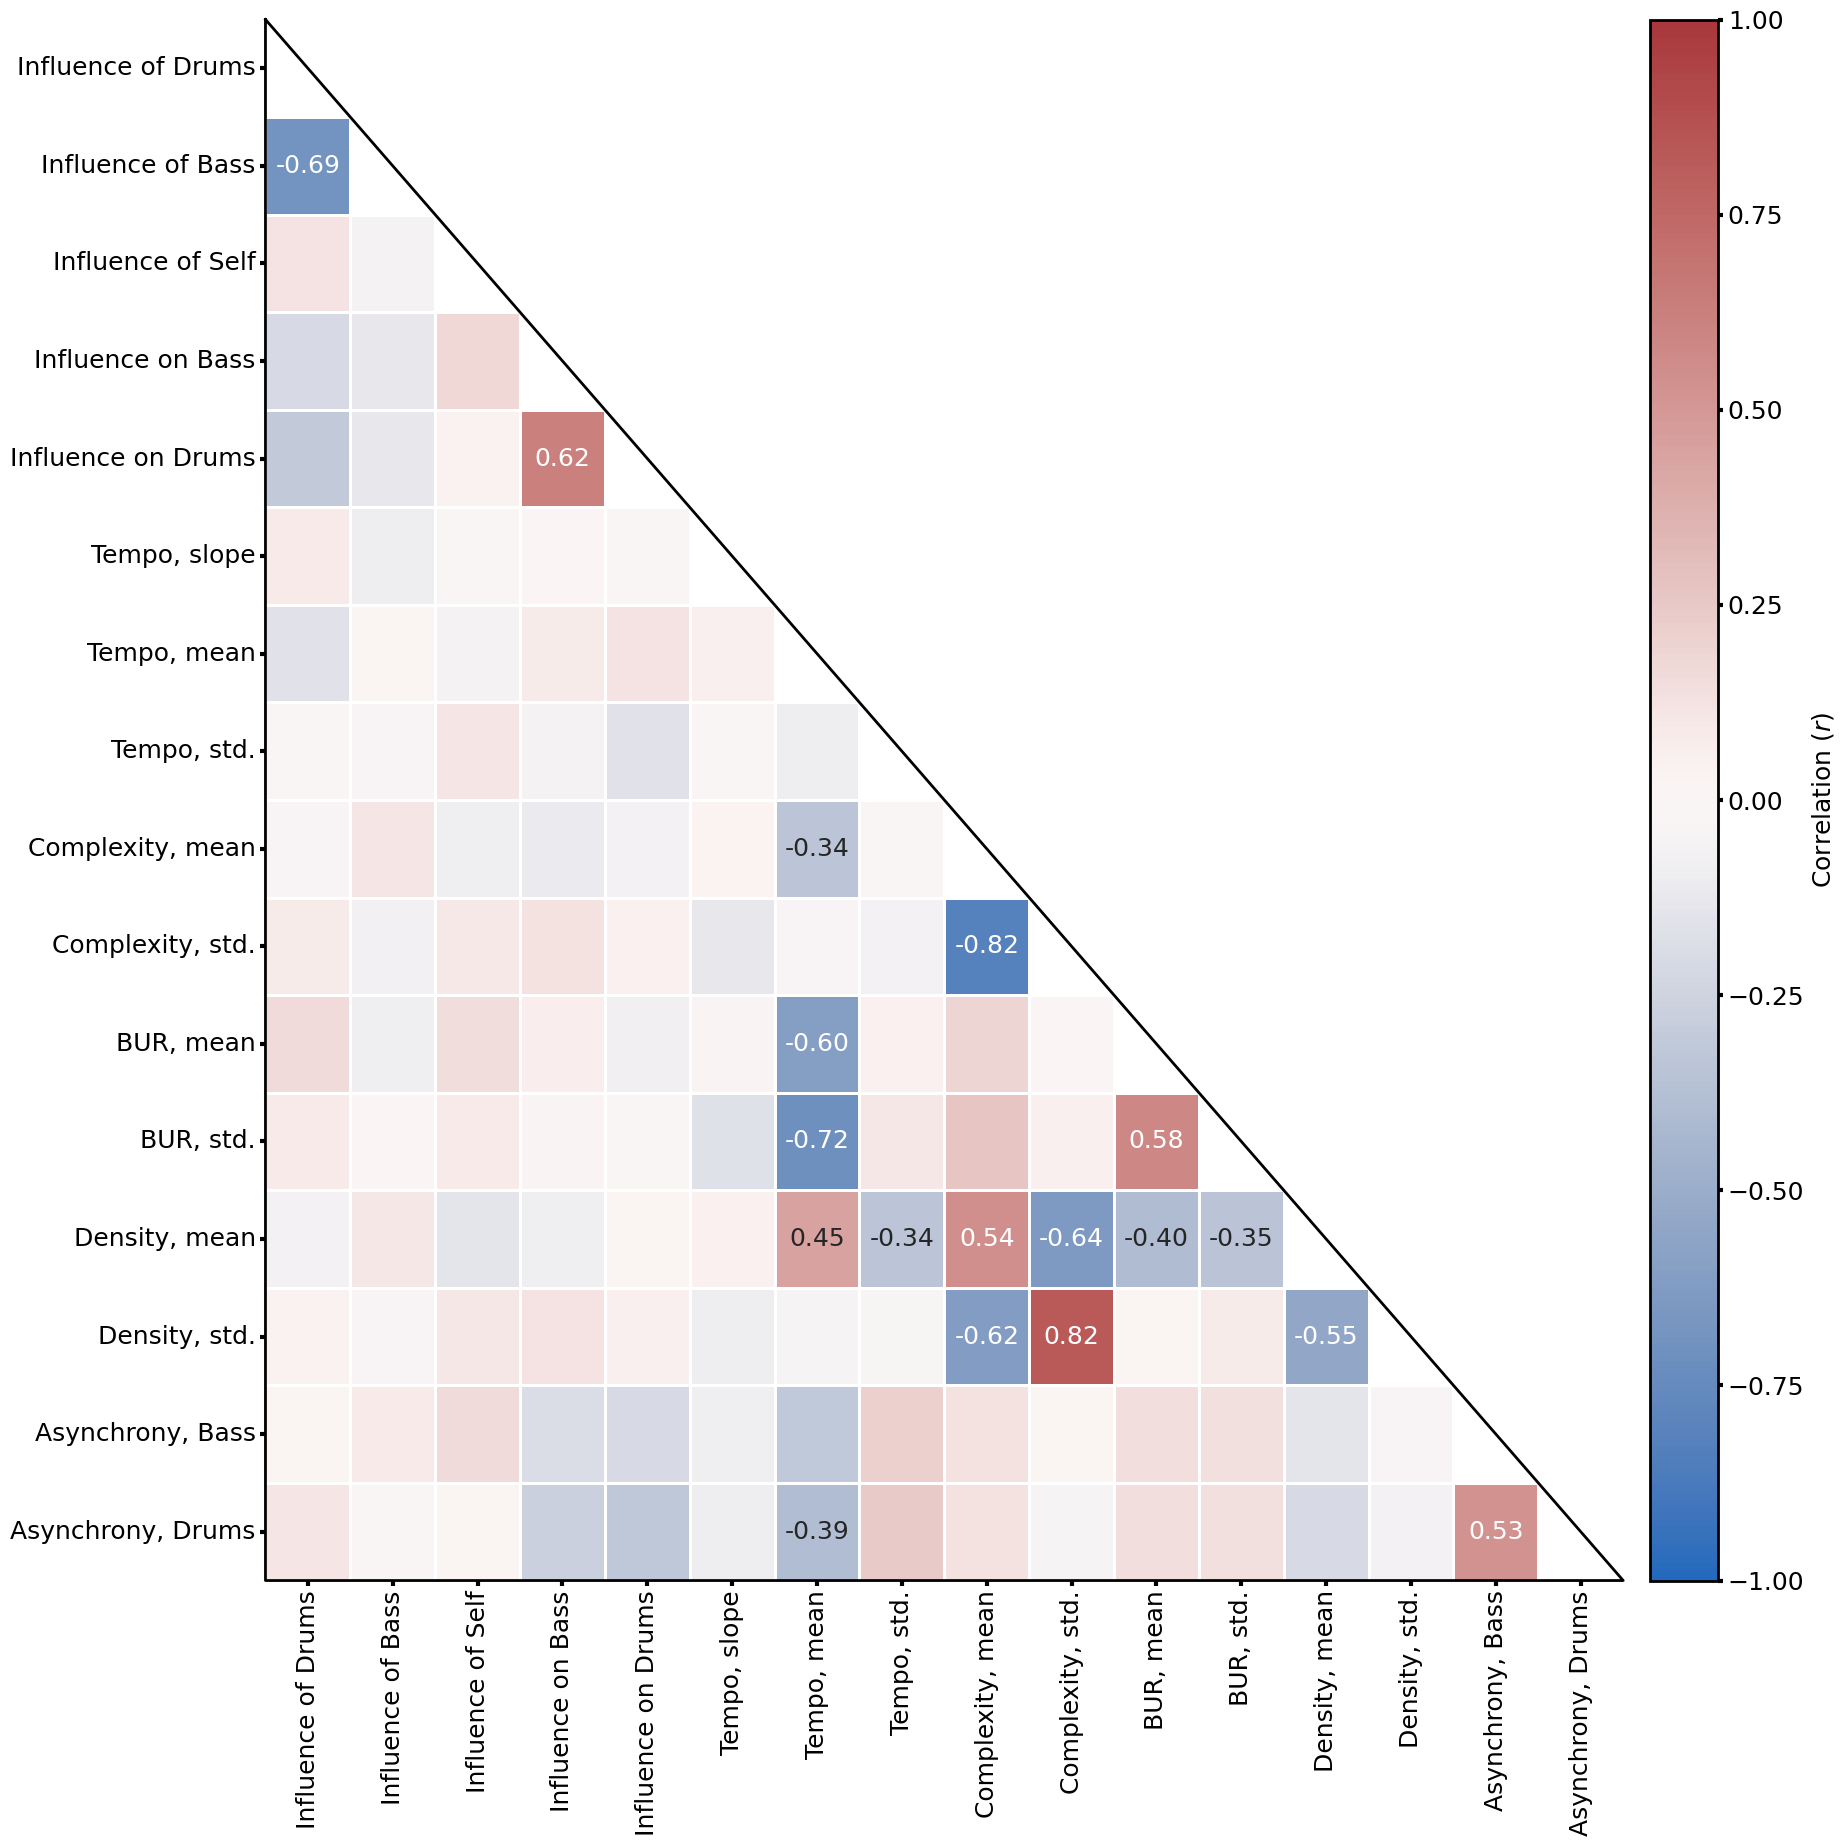

In [116]:
class HeatMapFeatureCorrelation(vutils.BasePlot):
    col_mapping = {
        'bur_mean': 'BUR, mean',
        'ed_per_second_mean': 'Density, mean',
        'rolling_std_median': 'Tempo, std.',
        'entropy_median': 'Complexity, mean',
        'entropy_mean': 'Complexity, mean',
        'entropy_std': 'Complexity, std.',
        'tempo': 'Tempo, mean',
        'ed_per_second_std': 'Density, std.',
        'coupling_bass': 'Influence of Bass',
        'bass_async_mean_pairwise_asynchrony': 'Asynchrony, Bass',
        'drums_async_mean_pairwise_asynchrony': 'Asynchrony, Drums',
        'tempo_slope': 'Tempo, slope',
        'mean_relative_asynchrony': 'Asynchrony, Group',
        'bur_std': 'BUR, std.',
        'self_coupling': 'Influence of Self',
        'coupling_drums_piano': 'Influence on Drums',
        'coupling_bass_piano': 'Influence on Bass',
        'coupling_drums': 'Influence of Drums'
    }
    def __init__(self, features: pd.DataFrame, **kwargs):
        self.corpus_title = 'corpus_chronology'
        self.df = features
        super().__init__(figure_title=fr'random_forest_plots\heatmap_feature_correlations_{self.corpus_title}', **kwargs)
        self.fig = plt.figure(figsize=(vutils.WIDTH, vutils.WIDTH))
        self.gs0 = mpl.gridspec.GridSpec(1, 2, width_ratios=[40, 1], hspace=0.0)
        self.ax = self.fig.add_subplot(gs0[0])
        self.cax = self.fig.add_subplot(gs0[1])

    def _create_plot(self):
        corr = self.df.rename(columns=self.col_mapping).corr()
        matrix = np.triu(corr)
        g = sns.heatmap(
            corr, cbar_ax=self.cax, ax=self.ax, cmap='vlag', mask=matrix, vmin=-1, vmax=1, annot=True,
            fmt='.2f', annot_kws={'size': vutils.FONTSIZE}, cbar_kws={'label': 'Correlation ($r$)'},
            linecolor=vutils.WHITE, linewidths=vutils.LINEWIDTH/2,
        )
        s = len(corr)
        g.plot([0, s, 0, 0], [0, s, s, 0], clip_on=False, color=vutils.BLACK, lw=vutils.LINEWIDTH)
        return g

    def _format_cax(self):
        self.cax.tick_params(axis='both', width=vutils.TICKWIDTH, color=vutils.BLACK)
        for spine in self.cax.spines:
            self.cax.spines[spine].set_color(vutils.BLACK)
            self.cax.spines[spine].set_linewidth(vutils.LINEWIDTH)

    def _format_corr_labels(self, lim: float = 1/3):
        for t in self.ax.texts:
            if abs(float(t.get_text())) > lim:
                t.set_text(t.get_text())
            else:
                t.set_text('')

    def _format_ax(self):
        self.ax.tick_params(axis='both', width=vutils.TICKWIDTH, color=vutils.BLACK)
        self._format_cax()
        self._format_corr_labels()

    def _format_fig(self):
        self.fig.tight_layout()

HeatMapFeatureCorrelation(X).create_plot()
plt.show()